# Skorch setting for 11 inputs and 5 outputs 
- 11개 inputs: 과거 32tic 데이터를 이용
- [경로] G:\nox\2024\nox_05sec

In [1]:
import argparse
import math
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset

import numpy as np;

import pdb
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Image

In [2]:
import pickle
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, Callback
from skorch.helper import predefined_split

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # CUDA연산을 동기화모드로 전환
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.cuda.set_device(0)  # 0번 GPU
torch.manual_seed(20201130)  # torch연산의 재현성 보장
torch.cuda.manual_seed(20201130)  # CUDA연산의 재현성 보장

In [4]:
data_files = ['train_data/busan_5gt_nox6.npy']

In [6]:
class NOxDataBase(Dataset):
    #
    # 입력 샘플이 바뀔때마다 특징의 max, min값이 바뀌는 것을 방지하기 위해, 미리 설정:
    #
    user_maximum = [10, 40, 12, 10, 100, 500, 1100, 200, 25, 120, 10, 23, 350, 200, 7000, 700, 350, 200, 120000, 100, 100, 100, 10]
    user_minimum = [ 0,-10,  0,  0,   0,   0,    0,   0,  0,   0,  0,  0, 100,   0, 2000,   0, 100,   0,      0,   0,   0,   0,  0]
    
    def __init__(self, data_name=data_files):
        self._load_data(data_name)
        self._normalize()
        print(self.train_x.shape, self.train_y.shape)
        print(self.valid_x.shape, self.valid_y.shape)
        
    def _load_data(self, data_name):
        self.data_dict = [np.load(in_data, allow_pickle='TRUE').item() for in_data in data_name]
        self.train_x = np.concatenate(tuple([a1['train_x'] for a1 in self.data_dict]),axis=0)
        self.train_y = np.concatenate(tuple([a1['train_y'] for a1 in self.data_dict]),axis=0)
        self.valid_x = np.concatenate(tuple([a1['valid_x'] for a1 in self.data_dict]),axis=0)
        self.valid_y = np.concatenate(tuple([a1['valid_y'] for a1 in self.data_dict]),axis=0)       
        self.maximum = np.ones(self.train_x.shape[2])
        self.minimum = np.ones(self.train_x.shape[2])

    def _normalize(self):
        self.maximum = self.user_maximum
        self.minimum = self.user_minimum
        for v in range(self.train_x.shape[2]):
            #self.maximum[v] = np.max(self.train_x[:,:,v])
            #self.minimum[v] = np.min(self.train_x[:,:,v])            
            
            denom = self.maximum[v]-self.minimum[v]
            self.train_x[:,:,v] = np.clip((self.train_x[:,:,v]-self.minimum[v]) / denom, 0.0, 1.0)
            self.train_y[:,:,v] = np.clip((self.train_y[:,:,v]-self.minimum[v]) / denom, 0.0, 1.0)
            self.valid_x[:,:,v] = np.clip((self.valid_x[:,:,v]-self.minimum[v]) / denom, 0.0, 1.0)
            self.valid_y[:,:,v] = np.clip((self.valid_y[:,:,v]-self.minimum[v]) / denom, 0.0, 1.0)
            
        print('Max value of features = {}'.format(self.maximum))
        print('Min value of features = {}'.format(self.minimum))       
        
        
class NOxTrain(NOxDataBase):
    def __len__(self):
        return len(self.train_x)
    
    def __getitem__(self, idx):
        return self.train_x[idx], self.train_y[idx,0:5,:]
    
class NOxValid(NOxDataBase):
    def __len__(self):
        return len(self.valid_x)
    
    def __getitem__(self, idx):
        return self.valid_x[idx], self.valid_y[idx,0:5,:]
    
    
train_data = NOxTrain(data_files)
print('------------------------------')
valid_data = NOxValid(data_files)
print('------------------------------')
print(valid_data.data_dict[0].keys())
#print(valid_data.data_dict[0]['features'])
valid_data.data_dict[0]['tic'], valid_data.data_dict[0]['Data_date']

Max value of features = [10, 40, 12, 10, 100, 500, 1100, 200, 25, 120, 10, 23, 350, 200, 7000, 700, 350, 200, 120000, 100, 100, 100, 10]
Min value of features = [0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 2000, 0, 100, 0, 0, 0, 0, 0, 0]
(380000, 32, 23) (380000, 16, 23)
(131100, 32, 23) (131100, 16, 23)
------------------------------
Max value of features = [10, 40, 12, 10, 100, 500, 1100, 200, 25, 120, 10, 23, 350, 200, 7000, 700, 350, 200, 120000, 100, 100, 100, 10]
Min value of features = [0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 2000, 0, 100, 0, 0, 0, 0, 0, 0]
(380000, 32, 23) (380000, 16, 23)
(131100, 32, 23) (131100, 16, 23)
------------------------------
dict_keys(['train_x', 'train_y', 'valid_x', 'valid_y', 'File', 'Date', 'tic', 'ID', 'loc', 'Data_date', 'cut_len', 'features'])


('5sec', '241202+250113')

In [7]:
print(len(train_data), len(valid_data))
print(train_data[0][0].shape)  
print(train_data[0][1].shape)  

# Test를 위해 필요함
train_dataloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=2048, pin_memory=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, shuffle=False, batch_size=2048, pin_memory=True)
inp = next(iter(train_dataloader))
inp[0].shape, inp[1].shape

380000 131100
(32, 23)
(5, 23)


(torch.Size([2048, 32, 23]), torch.Size([2048, 5, 23]))

### Model

In [8]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size, 1, bias=False)
    
    def forward(self, hidden_states):
        # hidden_states: [batch_size, seq_len, hidden_size]
        attention_scores = self.attention(hidden_states)  # [batch_size, seq_len, 1]
        attention_weights = torch.softmax(attention_scores, dim=1)  # [batch_size, seq_len, 1]
        context_vector = torch.sum(hidden_states * attention_weights, dim=1)  # [batch_size, hidden_size]
        return context_vector, attention_weights

In [10]:
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.attention = Attention(hidden_size)
        self.input_projection = nn.Linear(input_size, hidden_size, bias=False) if input_size != hidden_size else None
        self.dropout_lstm = nn.Dropout(0.3)
        self.dropout_attention = nn.Dropout(0.5)
        self.fc = nn.Linear(3*hidden_size, output_size)
        self.embedding_x2 = nn.Linear(1, hidden_size)
        self.embedding_x3 = nn.Linear(5, hidden_size)
    
    def forward(self, x1, x2, x3):
        lstm_output, _ = self.lstm(x1)  # [batch_size, seq_len, hidden_size]
        lstm_output = self.dropout_lstm(lstm_output)
        context_vector, attention_weights = self.attention(lstm_output)  # [batch_size, hidden_size]
        
        # Residual connection: Project input mean if input_size != hidden_size
        input_mean = torch.mean(x1, dim=1)  # [batch_size, input_size]
        if self.input_projection is not None:
            input_mean = self.input_projection(input_mean)  # Match dimensions: [batch_size, hidden_size]
        context_vector = context_vector + input_mean  # Residual connection

        #pdb.set_trace()
        embedded_x2 = self.embedding_x2(x2)
        embedded_x3 = self.embedding_x3(x3)
        combined_vector = torch.cat((context_vector, embedded_x2, embedded_x3), dim=1)
        combined_vector = self.dropout_attention(combined_vector)
        
        # Fully connected layer
        output = self.fc(combined_vector)  # [batch_size, output_size]
        
        return output   


model = LSTMWithAttention(11, 64, 1, num_layers=1, dropout=0.0)

In [11]:
def model_data(inputs):
    x1 = []
    x2 = []
    x3 = []
    y1 = []
    
    indx = [0,1,5,6,8,11,12,13,15,16,18]
    for aa in inputs:  # aa[0]=(32, 21), aa[1]=(21,)
        x1.append(aa[0][:,indx])  
        x2.append(aa[0][0,21:22])
        x3.append(aa[1][:5,6])
        y1.append(aa[1][:5,21])

    x1 = np.array(x1, dtype=np.float32)
    x2 = np.array(x2, dtype=np.float32)
    x3 = np.array(x3, dtype=np.float32)
    y1 = np.array(y1, dtype=np.float32)
    return x1, x2, x3, y1


train_x1, train_x2, train_x3, train_y1 = model_data(train_data)
valid_x1, valid_x2, valid_x3, valid_y1 = model_data(valid_data)
train_x1.shape, train_x2.shape, train_x3.shape, train_y1.shape, valid_x1.shape, valid_x2.shape, valid_x3.shape, valid_y1.shape, 

((380000, 32, 11),
 (380000, 1),
 (380000, 5),
 (380000, 5),
 (131100, 32, 11),
 (131100, 1),
 (131100, 5),
 (131100, 5))

In [12]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, x1, x2, x3, y):
        self.x1 = x1
        self.x2 = x2
        self.x3 = x3
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {'x1': self.x1[idx], 'x2': self.x2[idx], 'x3':self.x3[idx]}, self.y[idx]

    
valid_dataset = CustomDataset(valid_x1, valid_x2, valid_x3, valid_y1)
train_dict = {'x1': train_x1, 'x2': train_x2, 'x3': train_x3}

In [12]:
# PyTorch TensorDataset으로 변환
# train_dataset = TensorDataset(torch.tensor(train_x0), torch.tensor(train_y0))
# valid_dataset = TensorDataset(torch.tensor(valid_x0), torch.tensor(valid_y0))
# train_dataset[0][0].shape, train_dataset[0][1].shape

In [13]:
class TimeCallback(Callback):
    def on_epoch_end(self, net, dataset_train=None, dataset_valid=None, **kwargs):
        current_time = time.strftime('%m-%d %H:%M:%S')
        if 'epoch_time' not in net.history[-1]:
            net.history[-1]['epoch_time'] = current_time

        train_loss = net.history[-1]['train_loss']
        # L2 패널티 계산
        l2_loss = sum(param.pow(2).sum() for param in net.module_.parameters())
        net.history[-1]['W Sum'] = l2_loss.item()        
        weight_decay = net.optimizer_.param_groups[0].get('weight_decay', 0)
        l2_loss *= weight_decay
        net.history[-1]['W_decay'] = weight_decay
        net.history[-1]['L2 Loss'] = l2_loss.item()
        total_loss = train_loss + l2_loss.item()   

In [14]:
class DynamicWeightDecay(Callback):
    def __init__(self, initial_decay=0.000001, decay_factor=0.99):
        self.initial_decay = initial_decay
        self.decay_factor = decay_factor

    def on_epoch_begin(self, net, **kwargs):
        current_epoch = len(net.history)
        new_weight_decay = self.initial_decay * (self.decay_factor ** current_epoch)
        for param_group in net.optimizer_.param_groups:
            param_group['weight_decay'] = new_weight_decay

In [15]:
for ii in range(15,16):
    weight_decay = 0.0000001 + 2*ii*0.0000001
    out_pts = f"pts/best_params_nox_alone_att_res_mse{ii}.pt"
    print(f"Iter:{ii}, weight_decay:{weight_decay:.8f}, pts: {out_pts}")
    
    model = LSTMWithAttention(11, 64, 5, num_layers=1, dropout=0.0)

    regressor = NeuralNetRegressor(
        model,
        max_epochs=1,  # 50
        #lr=0.0001,
        #criterion=nn.SmoothL1Loss, # or MSE 
        optimizer=torch.optim.AdamW,  # or AdamW
        optimizer__lr=0.0001,  
        optimizer__weight_decay=weight_decay,  # L2 regularization    
        # optimizer__weight_decay=0.000005,  # L2 regularization    
        iterator_train__shuffle=True,
        batch_size=2048,
        train_split=predefined_split(valid_dataset),
        callbacks=[Checkpoint(f_params=out_pts),
                   TimeCallback(),
                   DynamicWeightDecay(initial_decay=weight_decay, decay_factor=0.99)
                  ],
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    ) 

    # regressor.fit(train_dataset, y=None)  
    regressor.fit(train_dict, train_y1) 

Iter:15, weight_decay:0.00000310, pts: pts/best_params_nox_alone_att_res_mse15.pt
  epoch    L2 Loss     W Sum    W_decay      epoch_time    train_loss    valid_loss    cp     dur
-------  ---------  --------  ---------  --------------  ------------  ------------  ----  ------
      1     0.0006  192.2798     0.0000  01-23 16:30:19        0.0895        0.0056     +  7.9068


In [17]:
#model.load_state_dict(torch.load('pts/best_params_11f_NOX_0002.pt', weights_only=True))
regressor.module_.load_state_dict(torch.load('pts/best_params_nox_alone_att_res_mse15_3inputs_0003.pt', weights_only=True))

<All keys matched successfully>

In [18]:
import gc

torch.cuda.empty_cache()  # 캐시된 메모리 해제, 사용되지 않는 GPU메모리 해제
gc.collect()  # Python garbage collection (선택적)

8

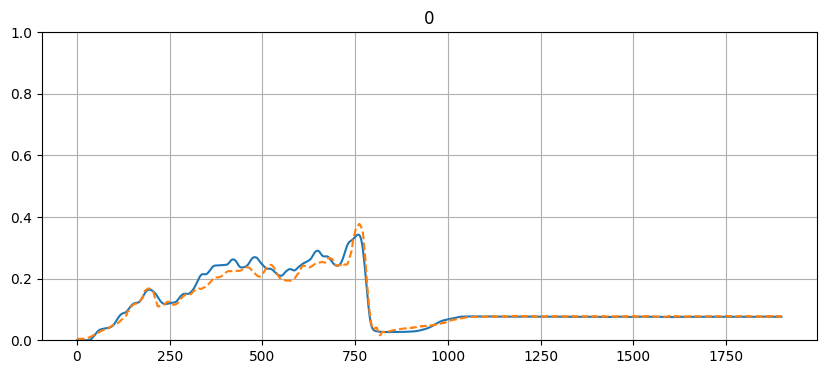

In [19]:
def plot_valid(crop_num):
    crop_len = 1900
    
    st, et = crop_num*crop_len, (crop_num+1)*crop_len
    valid_dict = {'x1': valid_x1[st:et], 'x2': valid_x2[st:et], 'x3': valid_x3[st:et]}
    res = regressor.predict(valid_dict)  
    #pdb.set_trace()

    plt.figure(figsize=(10,4))
    plt.title(f"{crop_num}")
    #plt.xlim(500,1000)
    plt.ylim(0,1)
    plt.grid()
    plt.plot(valid_y1[st:et,4], label='NOx(Ground)')  
    plt.plot(res[:,4],'--', label='NOx(predict)')    
    plt.show()


for ii in range(1):
    plot_valid(ii)

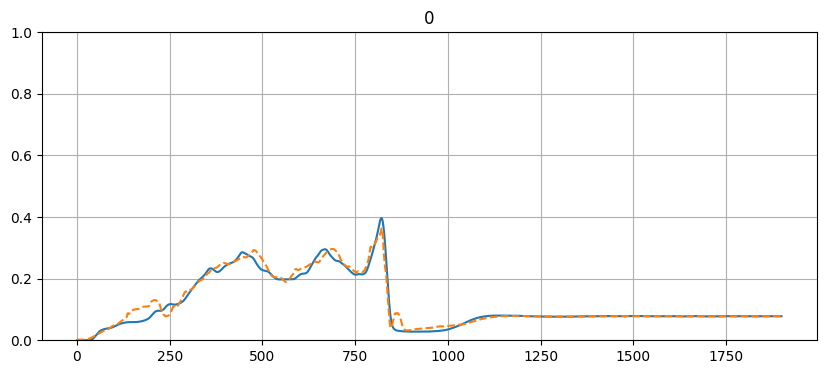

In [20]:
def plot_valid(crop_num):
    crop_len = 1900
    
    st, et = crop_num*crop_len, (crop_num+1)*crop_len
    train_dict = {'x1': train_x1[st:et], 'x2': train_x2[st:et], 'x3': train_x3[st:et]}
    res = regressor.predict(train_dict)  

    plt.figure(figsize=(10,4))
    plt.title(f"{crop_num}")
    plt.ylim(0,1)
    plt.grid()
    plt.plot(train_y1[st:et,0], label='NOx(Ground)')  
    plt.plot(res[:,0],'--', label='NOx(predict)')    
    plt.show()


for ii in range(1):
    plot_valid(ii)

In [22]:
models = [LSTMWithAttention(11, 64, 5, num_layers=1, dropout=0.0) for _ in range(5)]
# for model,ii in zip(models, [15,16,18,22,23]):
#     model.load_state_dict(torch.load(f'pts/best_params_nox_alone{ii}.pt', weights_only=True))
#     model.eval()

# X_tensor = torch.from_numpy(valid_x0).cuda()
# ensemble_preds = []
# for model in models:
#     model.cuda()
#     with torch.no_grad():
#         preds = model(X_tensor) 
#         ensemble_preds.append(preds)

# ensemble_output = torch.mean(torch.stack(ensemble_preds), dim=0)
# print(ensemble_output.shape)

# for crop_num in range(12):
#     crop_len = 1900
#     st, et = crop_num*crop_len, (crop_num+1)*crop_len
#     res = ensemble_output[st:et,0].cpu().numpy()  

#     plt.figure(figsize=(10,4))
#     plt.ylim(0,1)
#     plt.grid()
#     plt.plot(valid_y0[st:et,0], label='NOx(Ground)')  
#     plt.plot(res,'--', label='NOx(predict)')    
#     plt.show()

def plot_valid(crop_num):
    crop_len = 1900
    
    st, et = crop_num*crop_len, (crop_num+1)*crop_len
    res = regressor.predict(train_x0[st:et])  

    plt.figure(figsize=(10,4))
    plt.title(f"{crop_num}")
    plt.ylim(0,1)
    plt.grid()
    plt.plot(train_y1[st:et,0], label='NOx(Ground)')  
    plt.plot(res,'--', label='NOx(predict)')    
    plt.show()


# for ii in range(195):
#     plot_valid(ii)

In [23]:
models = [LSTMWithAttention(11, 64, 5, num_layers=1, dropout=0.0) for _ in range(5)]
# for model,ii in zip(models, [15,16,18,22,23]):
#     model.load_state_dict(torch.load(f'pts/best_params_nox_alone{ii}.pt', weights_only=True))
#     model.eval()

# X_tensor = torch.from_numpy(train_x0).cuda()
# ensemble_preds = []
# for model in models:
#     model.cuda()
#     with torch.no_grad():
#         preds = model(X_tensor) 
#         ensemble_preds.append(preds)

# ensemble_output = torch.mean(torch.stack(ensemble_preds), dim=0)
# print(ensemble_output.shape)

# for crop_num in range(90):
#     crop_len = 1900
#     st, et = crop_num*crop_len, (crop_num+1)*crop_len
#     res = ensemble_output[st:et,0].cpu().numpy()  

#     plt.figure(figsize=(10,4))
#     plt.title(f"{crop_num}")
#     plt.ylim(0,1)
#     plt.grid()
#     plt.plot(train_y0[st:et,0], label='NOx(Ground)')  
#     plt.plot(res,'--', label='NOx(predict)')    
#     plt.show()